In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import jax
import jax.numpy as jnp
from tinyjaxley.modules.comp import Compartment
from tinyjaxley.modules.branch import Branch
# from tinyjaxley.modules.cell import Cell
from tinyjaxley.channels.hh import Na, K, Leak
import matplotlib.pyplot as plt
from tinyjaxley.solvers import fw_euler
import pandas as pd
from diffrax import diffeqsolve, ODETerm, SaveAt, Dopri5
import equinox as eqx
from jax import lax

- recurse into channels -> set and get should work for example
    - submodules should get custom method for each module, i.e. comp.channels -> comp.submodules, branch.comps -> branch.submodules, etc.
- fix `comp.set(("k", "n"), 0.0)` same for `clamp` and `record`
- tests to assert against jaxley

In [8]:
comp = Compartment()
# comp.record("v")
comp.insert(Leak())
comp.insert(Na())
comp.insert(K())
comp.stimulate(lambda t, u: jnp.array([0.01]))

t0 = 0
u0 = comp.all_states
# comp.set("v", -70.0)
u0 = comp.init()

In [13]:
ode = ODETerm(comp.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat)

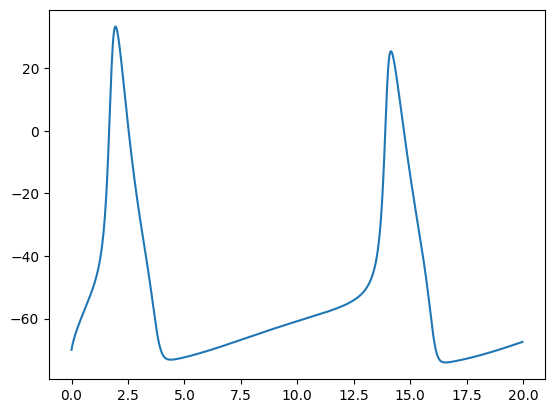

In [16]:
plt.plot(sol.ts, sol.ys[0]["v"])

In [10]:
branch = Branch([Compartment()]*10)
# branch.record("v")
branch.insert(Leak())
branch.insert(Na())
branch.insert(K())
# branch.comp(0).stimulate(lambda t, u, p: 0.05)
# branch.comp(1).stimulate(lambda t, u, p: -0.05)

# t0 = 0
u0 = branch.all_states
# u0 = branch.init(t0, branch.states, branch.params)
# branch.set("v", -70.0)

In [5]:
ode = ODETerm(branch.vf)
tspan = (0, 20)
ts = jnp.arange(*tspan, 0.025)
saveat = SaveAt(ts = ts)
sol = diffeqsolve(ode, Dopri5(), *tspan, y0 = u0, dt0 = 0.025, saveat = saveat, args = p)

In [15]:
from copy import deepcopy
leak = Leak()
leak_copy = deepcopy(leak)

leak_copy.vf = leak.vf

In [17]:
leak.vf = jax.jit(leak.vf)

<function tinyjaxley.channels.hh.Leak.vf(t, u, p, v)>